In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles,make_blobs,make_moons

In [2]:
def sigmoid(x):
    #sigmoid
    return 1/(1+np.exp(-x));
    #relu function
    y=x
    y[x<0]=0
    return y

def relu(x):
    #relu function
    y=x
    y[x<0]=0
    return y


def tan_inv(x):
    #tanh
    return np.tanh(x)

activations={'sigmoid':sigmoid,'relu':relu,'tanh':tan_inv}

def sigmoid_diff(x):
    # first differential of activation function
    #sigmoid:
    """
    sigmoid'(x)=sigmoid(x)*(1-sigmoid(x))
    """
    sig=sigmoid(x)
    return sig*(1-sig) # element wise multiplication
def relu_diff(x):
    # first differential of activation function
    #relu:
    y=x
    y[x<0]=0
    y[x>0]=1
    return y
def tanh_diff(x):
    # first differential of activation function
    #tanh
    y=tan_inv(x)
    return (1-np.square(y))
activations_differential={'sigmoid':sigmoid_diff,'relu':relu_diff,'tanh':tanh_diff}


def softmax(a):
    exp_a=np.exp(a)
    exp_sum=np.sum(exp_a,axis=1,keepdims=True)
    return exp_a/exp_sum

In [3]:
class NeuralNetwork:
    def __init__(self,n,no_of_neurons,no_of_features,activation_function):
        """
        n=total number of layers
        no_of_elements=total no of neurons in each layer(list)
        input_size= total no of input features
        activation_function=name of the activation funtion 
        """
        weights=[]# list of weight matrices
        biases=[]# list of biasis
        for i in range(n):
            col=no_of_neurons[i]
            if(i==0):
                row=no_of_features
            else:
                row=no_of_neurons[i-1]
            w=np.random.randn(row,col)# weight matrix for that layer
            weights.append(w)
            b=np.zeros((1,col))#bias for that layer
            biases.append(b)
        self.weights=weights;
        self.biases=biases
        self.n=n;
        self.activation_fun=activations[activation_function]
        self.activation_diff_fun=activations_differential[activation_function]
        self.no_of_classes=no_of_neurons[-1]
    def forward_propagation(self,X):
        #X->m X n matrix. m is the number of inputs and n is the number of features
        activation_list=[]
        z_list=[]
        weights=self.weights
        biases=self.biases
        activation_fun=self.activation_fun
        n=self.n
        
        prev_activation=X;
        for i in range(n):
            z=np.dot(prev_activation,weights[i])+biases[i]
            if(i<n-1):
                a=activation_fun(z)
            else:
                a=softmax(z)
            activation_list.append(a)
            z_list.append(z)
            prev_activation=a
        self.z_list=z_list;
        self.activation_list=activation_list
        return activation_list[-1]
    
    def backward_propagation(self,X,Y,learning_rate=0.01):
        """
        x->m X n matrix. m is the number of inputs and n is the number of features
        y-> actual outut
        
        """
        dw=[]# list of chanegs in matrices
        db=[]# list of changes in biases
        
        weights=self.weights
        biases=self.biases
        activation_list=self.activation_list
        z_list=self.z_list
        next_delta=0
        activation_diff_fun=self.activation_diff_fun
        n=self.n
        m=1
        for i in reversed(range(n)):
            if(i==n-1):
                delta=activation_list[i]-Y
            else :
                delta=np.dot(next_delta,weights[i+1].T)*activation_diff_fun(z_list[i])
            next_delta=delta
            
            if(i==0):
                dwi=np.dot(X.T,delta)/m
            else:
                dwi=np.dot(activation_list[i-1].T,delta)/m
            
            dbi=np.sum(delta,axis=0)/m
            dw.insert(0,dwi)
            db.insert(0,dbi)

        for i in range(n):
            weights[i]-=learning_rate*dw[i]
            biases[i]-=learning_rate*db[i]
        self.weights=weights
        self.biases=biases
    
    
    def predict(self,x):
        y_=self.forward_propagation(x)
        return np.argmax(y_,axis=1);
    def loss(self,y_oht,y_):
        return -np.mean(y_oht*np.log(y_))
            
        
        
            
            
            

In [4]:

def generate_dataset(type):
    if(type=='moons'or type=='moon'):
        X,Y=make_moons(n_samples=500,noise=0.2)
        return (X,Y)
    if(type=='circles'or type=='circle'):
        X,Y=make_circles(n_samples=500,  shuffle=True, noise=0.05, random_state=1, factor=0.8)
        return (X,Y)
    X,Y=make_blobs(500,2,centers=2,random_state=4)
    return (X,Y)

In [5]:
# convert the simple labels into one hot vector
def convert_to_oht(y,no_of_classes):
    m=y.shape[0]
    y_oht=np.zeros((m,no_of_classes))
    y_oht[range(m),y]=1
    return y_oht

def train(model,X,y,epochs=200,learning_rate=0.0001,logs=True):
    no_of_classes=model.no_of_classes
    y_oht=convert_to_oht(y,no_of_classes)
    losses=[]
    for i in range(epochs):
        y_=model.forward_propagation(X)
        l=model.loss(y_oht,y_)
        losses.append(l)
        if(logs):
            print("Iteration {}, loss= {}".format(i,l))
        model.backward_propagation(X,y_oht,learning_rate)
    return losses

def visualize_decision_boundry(X,Y,model):
    # X is only two featured
    [x0_min,x1_min]=np.min(X,axis=0)
    [x0_max,x1_max]=np.max(X,axis=0)
    x0=np.linspace(x0_min,x0_max,100)
    x1=np.linspace(x1_min,x1_max,100)
    x0,x1=np.meshgrid(x0,x1)
    x=np.zeros((x0.shape[0]*x0.shape[1],2))
    x[:,0]=x0.reshape(-1)
    x[:,1]=x1.reshape(-1)
    y_=model.predict(x)
    print(x.shape)
    print(y_.shape)
    
    plt.scatter(x[:,0],x[:,1],c=y_,cmap=plt.get_cmap('Accent'))
    plt.scatter(X[:,0],X[:,1],c=Y,cmap=plt.get_cmap("rainbow"))



moons



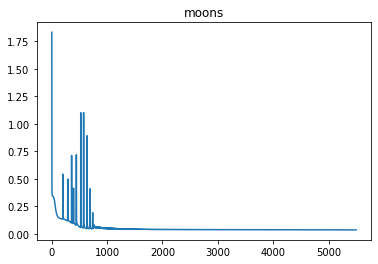

Efficiency=0.966
(10000, 2)
(10000,)


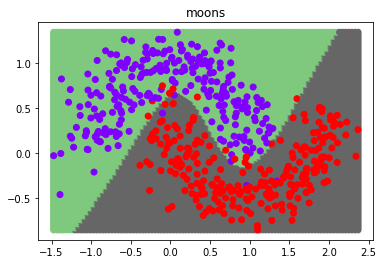


circles



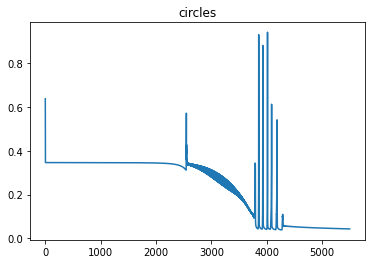

Efficiency=0.966
(10000, 2)
(10000,)


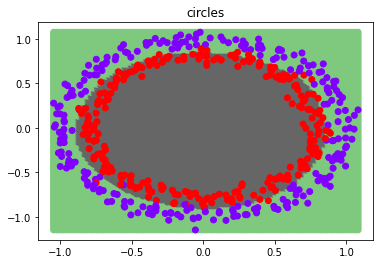


blobs



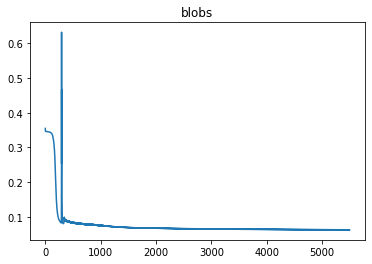

Efficiency=0.948
(10000, 2)
(10000,)


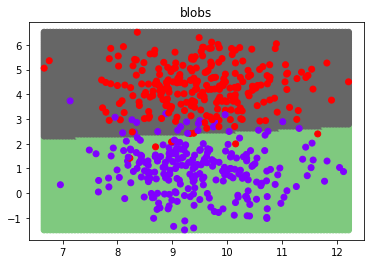

In [6]:
datasets=['moons','circles','blobs']
for d in datasets:
    print("\n{}\n".format(d))
    X,Y=generate_dataset(d)
    my_model=NeuralNetwork(6,[15,10,15,10,5,2],2,'sigmoid')
    losses=train(my_model,X,Y,5500,0.001,False)
    Y_=my_model.predict(X)
    plt.plot(losses)
    plt.title(d)
    plt.show()
    
    print("Efficiency={}".format(np.mean(np.array(Y_==Y))))
    
    visualize_decision_boundry(X,Y,my_model)
    plt.title(d)
    plt.show()

In [7]:
import neural_network as nn


moons



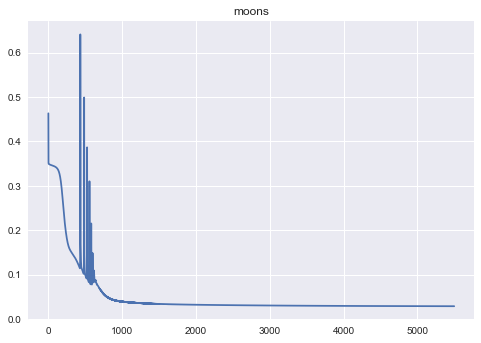

Efficiency=0.97
(10000, 2)
(10000,)


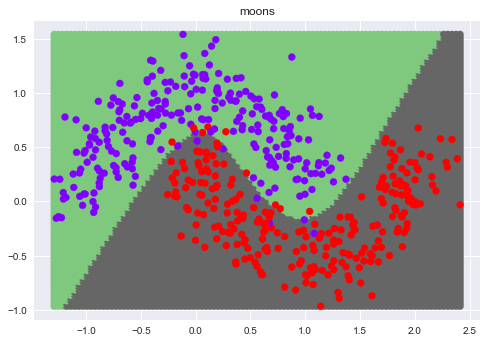


circles



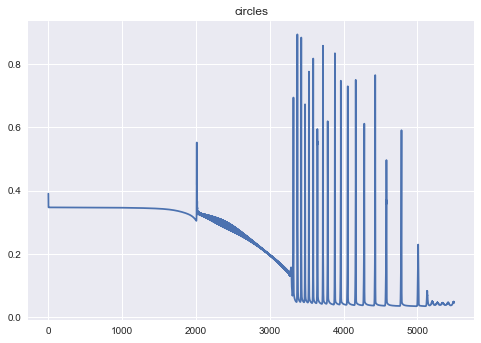

Efficiency=0.966
(10000, 2)
(10000,)


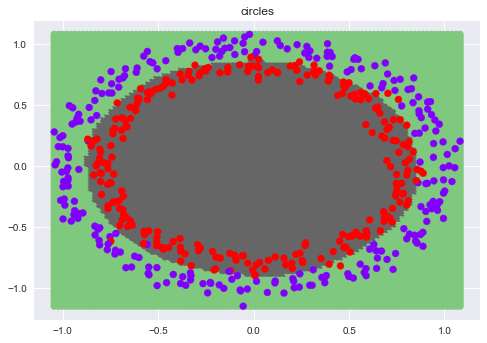


blobs



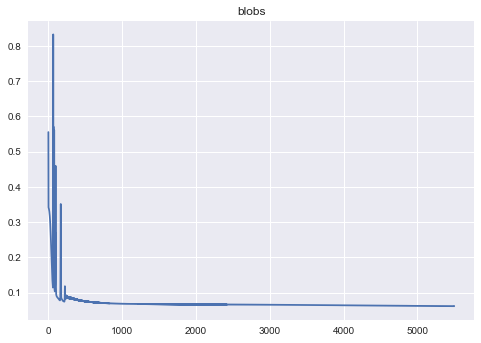

Efficiency=0.948
(10000, 2)
(10000,)


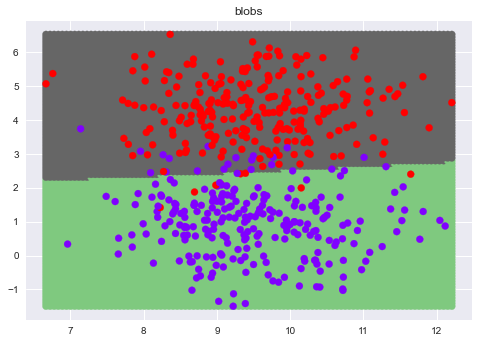

In [8]:
plt.style.use('seaborn')
datasets=['moons','circles','blobs']
for d in datasets:
    print("\n{}\n".format(d))
    X,Y=nn.generate_dataset(d)
    my_model=nn.NeuralNetwork(6,[15,10,15,10,5,2],2,'sigmoid')
    losses=nn.train(my_model,X,Y,5500,0.001,False)
    Y_=my_model.predict(X)
    plt.plot(losses)
    plt.title(d)
    plt.show()
    
    print("Efficiency={}".format(np.mean(np.array(Y_==Y))))
    
    nn.visualize_decision_boundry(X,Y,my_model)
    plt.title(d)
    plt.show()